<a href="https://colab.research.google.com/github/mgozon/DLG-UROP/blob/main/Batch_DLG_Evolution_Iris_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Batch-DLG Evolution - Iris Dataset
This notebook is based on the [Batch-DLG Iris Dataset](https://github.com/mgozon/DLG-UROP/blob/main/Batch_DLG_Iris_Dataset.ipynb), which implements the procedure in [Deep Leakage from Gradients](https://gist.github.com/Lyken17/91b81526a8245a028d4f85ccc9191884) on the Iris Dataset. In particular, a fully connected nueral network is trained using mini-batch gradients which are leaked.

# Setting up Libaries and Utilities

In [ ]:
# setting up machine learning/visualization libraries
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import grad
#torch.manual_seed(100) # for generating the same random weights
from torch.utils.data import RandomSampler
from torch.utils.data import random_split
from sklearn.preprocessing import StandardScaler

# setting up optimal device
print(torch.__version__)
device = "cpu"
if torch.cuda.is_available():
    device = "cuda"
print("Running on %s" % device)

1.13.1+cu116
Running on cpu


In [ ]:
#@title Adding dlg_stats and dlg_models
from google.colab import drive
drive.mount('/content/drive/')
%run 'drive/MyDrive/UROP/Project Files/dlg_models.ipynb'
drive.flush_and_unmount()

Mounted at /content/drive/
Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
defined: assign_guess(guess, gt_dataset, n, verbose = False): guess_perm
defined: assign_best(guess, gt_dataset, n, verbose = False): best_match
defined: compute_stats(guess_perm, gt_data, recovered_threshold = 0.25): rel_errors, recovered_rate, cos_angles
defined: batch_DLG_Adam(net, criterion, device, original_dy_dx, batch_size, gt_data_len, gt_onehot_label_len, epoch_mult = 500, w_decay = 1e-12, scheduler_k = 0.001, verbose = False): dummy_data, losses
defined: label_to_onehot(target, n_classes): onehot_target
defined: train_net_Adam(net, criterion, device, train_data, train_target, output_dim, batch_size = 32, epochs = 100): losses
defined: test_net(net, test_data, test_target): prints accuracy
defined: train_net_Adam_DLG(net, criterion, device, scaler, train_data, train_target, output_dim, batch_size = 32, epochs = 100, verbo

# Preprocess Iris Dataset

In [ ]:
# preprocess Iris Dataset for training
from sklearn.datasets import load_iris
dst = load_iris()
dst_length = dst.data.shape[0]
scaler = StandardScaler()
scaled_data = scaler.fit_transform(dst.data)

train_indices, test_indices = random_split(range(dst_length), [int(dst_length*4/5), int(dst_length*1/5)])
train_indices = train_indices.indices
test_indices = test_indices.indices
train_data = scaled_data[train_indices]; train_target = dst.target[train_indices]
test_data = scaled_data[test_indices]; test_target = dst.target[test_indices]

# require inputs/outputs to be 2D for uniformity
train_target = np.expand_dims(train_target, axis=1)
test_target = np.expand_dims(test_target, axis=1)

# reference variables for code
input_dim = 4
output_dim = 3

# Setting up Fully Connected Neural Network

In [ ]:
# ***not equivalent to nn.CrossEntropyLoss(), which combines both nn.LogSoftmax() and nn.NLLLoss()
def cross_entropy_for_onehot(pred, onehot_target):
   return torch.mean(torch.sum(- onehot_target * torch.log(pred), 1))

In [ ]:
# a fully connected neural network with random weights and biases
class FcNet(nn.Module):
    def __init__(self):
        super(FcNet, self).__init__()
        act = nn.Sigmoid
        self.body = nn.Sequential(
            nn.Linear(input_dim, 100),
            act(),
            nn.Linear(100, 100),
            act(),
            nn.Linear(100, 100),
            act(),
            nn.Linear(100, output_dim),
            nn.Softmax(dim=1),
        )
        
    def forward(self, x):
        out = self.body(x)
        return out

def weights_init(m):
    if hasattr(m, "weight"):
        nn.init.xavier_normal_(m.weight.data)
    if hasattr(m, "bias"):
        nn.init.normal_(m.bias.data)

# instantiation
net = FcNet().to(device)
net.apply(weights_init)
criterion = cross_entropy_for_onehot

# Train Model Normally

score: 29/30


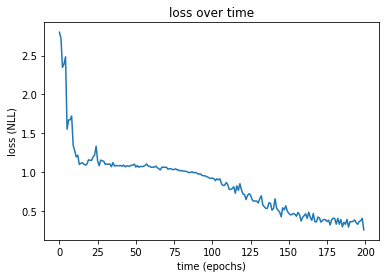

In [ ]:
# note that parameters batch_size and epochs are tuned to yield a more accurate model
net.apply(weights_init)
batch_size = 32 # this affects the smoothness of the loss graph
epochs = 200
losses = train_net_Adam(net, criterion, device, train_data, train_target, output_dim, batch_size, epochs)
test_net(net, test_data, test_target)

plt.plot(list(range(epochs)), losses)
plt.title('loss over time')
plt.xlabel('time (epochs)')
plt.ylabel('loss (NLL)')
plt.show()

# Testing Single Batch DLG

In [ ]:
# process specific batch gradient of flowers
def batch_grad(flower_indices):
    n = len(flower_indices)
    # flower_indices = torch.tensor(flower_indices)

    gt_data = torch.tensor(dst.data[flower_indices]).to(device)
    gt_label = torch.tensor(dst.target[flower_indices]).to(device); gt_label = torch.unsqueeze(gt_label, dim=1)
    gt_onehot_label = label_to_onehot(gt_label, n_classes=output_dim)

    out = net(gt_data.float())
    loss = criterion(out, gt_onehot_label)
    batch_dy_dx = torch.autograd.grad(loss, net.parameters())
    original_dy_dx = list((_.detach().clone() for _ in batch_dy_dx)) # share the gradients with other clients
    
    return original_dy_dx, gt_data, gt_label

[95, 38, 87, 124, 21, 4, 72, 53, 96, 37, 149, 83, 129, 111, 101, 40]


  0%|          | 0/8000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([5.7000, 3.0000, 4.2000, 1.2000], dtype=torch.float64) tensor([5.6314, 3.4545, 3.5011, 0.9524], grad_fn=<SelectBackward0>) RE (AE / TN):  0.11209576750587712
tensor([4.4000, 3.0000, 1.3000, 0.2000], dtype=torch.float64) tensor([4.1840, 3.2975, 0.9817, 0.4351], grad_fn=<SelectBackward0>) RE (AE / TN):  0.09847443009863766
tensor([6.3000, 2.3000, 4.4000, 1.3000], dtype=torch.float64) tensor([6.1029, 2.0843, 4.4432, 1.1059], grad_fn=<SelectBackward0>) RE (AE / TN):  0.04349436811630517
tensor([6.7000, 3.3000, 5.7000, 2.1000], dtype=torch.float64) tensor([7.8186, 6.6522, 6.4480, 2.2753], grad_fn=<SelectBackward0>) RE (AE / TN):  0.3756554507726016
tensor([5.1000, 3.7000, 1.5000, 0.4000], dtype=torch.float64) tensor([6.4593, 5.6839, 3.5495, 1.1063], grad_fn=<SelectBackward0>) RE (AE / TN):  0.4989454474179752
tensor([5.0000, 3.6000, 1.4000, 0.2000], dtype=torch.float64) tensor([ 4.8641,  3.3107,  0.9519, -0.0356], grad_fn=<SelectBackwar

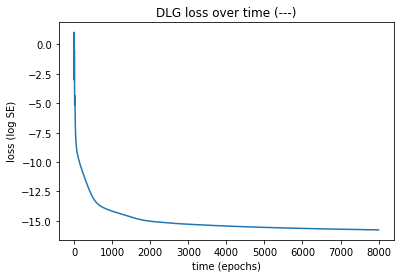

In [ ]:
# testing batch-DLG with Adam
net.apply(weights_init) # see how much easier it is to attack
batch_size = 16
flower_indices = list(RandomSampler(range(dst.data.shape[0]), num_samples=batch_size))
print(flower_indices)
batch_dy_dx, gt_data, gt_label = batch_grad(flower_indices)

dummy_data, losses = batch_DLG_Adam(net, criterion, device, batch_dy_dx, batch_size, gt_data_len = input_dim, gt_onehot_label_len = output_dim, epoch_mult = 500, w_decay = 1e-12, scheduler_k = 0.01, verbose = False)
guess_perm = assign_guess(dummy_data, gt_data, batch_size, verbose = True)       # assign all
assign_best(dummy_data, gt_data, batch_size, verbose = True)                     # closest match

plt.plot(torch.log(torch.tensor(losses)))
plt.title('DLG loss over time (---)')
plt.xlabel('time (epochs)')
plt.ylabel('loss (log SE)')
plt.savefig('dlg8-.png', dpi=300)

# DLG Evolution

In [ ]:
# results of training a model + dlg
net.apply(weights_init)
epochs = 500
batch_size = 16
dlg_rate = 5
verbose = True
losses, dlg_timestamps, AA_REs, AA_RRate, AA_cos_angles, CA_REs, CA_RRate, CA_cos_angles, grad_norms \
    = train_net_Adam_DLG(net, criterion, device, scaler, train_data, train_target, output_dim, batch_size, epochs, verbose, dlg_rate, \
                         gt_data_len = input_dim, gt_onehot_label_len = output_dim, epoch_mult=500, w_decay=1e-12, scheduler_k = 0.01, leak_no_train = False)
test_net(net, test_data, test_target)

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/320 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([4.4000, 3.0000, 1.3000, 0.2000], dtype=torch.float64) tensor([ 2.3858,  0.8615, -0.8222, -1.7827]) RE (AE / TN):  0.75308359267141
tensor([5.0000, 3.6000, 1.4000, 0.2000], dtype=torch.float64) tensor([ 5.1722,  1.4088, -1.1086, -2.1197]) RE (AE / TN):  0.642678553370685
tensor([6.7000, 3.0000, 5.2000, 2.3000], dtype=torch.float64) tensor([ 0.8419, -0.2261, -9.1448, -0.8680]) RE (AE / TN):  1.7383149051987445
tensor([5.0000, 3.0000, 1.6000, 0.2000], dtype=torch.float64) tensor([ 5.8284,  1.8814, -0.2677,  1.4964]) RE (AE / TN):  0.44064669940574747
tensor([5.8000, 4.0000, 1.2000, 0.2000], dtype=torch.float64) tensor([ 1.4723, -0.1772, -6.0584, -1.7316]) RE (AE / TN):  1.3458483996294837
tensor([5.9000, 3.0000, 5.1000, 1.8000], dtype=torch.float64) tensor([5.5361, 1.6135, 2.1196, 3.4944]) RE (AE / TN):  0.4347529702740075
tensor([6.3000, 2.3000, 4.4000, 1.3000], dtype=torch.float64) tensor([6.6737e+00, 2.1699e+00, 4.9631e+00, 1.5701

  0%|          | 0/320 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([5.1000, 3.7000, 1.5000, 0.4000], dtype=torch.float64) tensor([8.7236, 3.7036, 0.7446, 6.1598]) RE (AE / TN):  1.0550864181996602
tensor([6.2000, 2.2000, 4.5000, 1.5000], dtype=torch.float64) tensor([7.4272, 2.6655, 2.6298, 4.8018]) RE (AE / TN):  0.4950720793593279
tensor([6.2000, 2.8000, 4.8000, 1.8000], dtype=torch.float64) tensor([6.0881, 2.5705, 5.1706, 4.4992]) RE (AE / TN):  0.32125279800999845
tensor([6.4000, 3.2000, 4.5000, 1.5000], dtype=torch.float64) tensor([7.7237, 3.6393, 5.9835, 5.2600]) RE (AE / TN):  0.49808233541068075
tensor([5.6000, 2.9000, 3.6000, 1.3000], dtype=torch.float64) tensor([6.2197, 2.8693, 2.6754, 4.4459]) RE (AE / TN):  0.4523717463304035
tensor([4.6000, 3.4000, 1.4000, 0.3000], dtype=torch.float64) tensor([ 4.8301,  3.9408, -0.6985,  2.7716]) RE (AE / TN):  0.5588145692043722
tensor([5.1000, 3.3000, 1.7000, 0.5000], dtype=torch.float64) tensor([7.0891, 2.9820, 1.3417, 4.9048]) RE (AE / TN):  0.7675

  0%|          | 0/320 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([6.0000, 2.2000, 5.0000, 1.5000], dtype=torch.float64) tensor([ 10.1680,   6.1793, -11.8819,  -4.0288]) RE (AE / TN):  2.2632340915799327
tensor([5.0000, 2.3000, 3.3000, 1.0000], dtype=torch.float64) tensor([11.9742,  6.2037, -9.5261, -2.1173]) RE (AE / TN):  2.375922230026593
tensor([5.7000, 2.8000, 4.1000, 1.3000], dtype=torch.float64) tensor([ 10.7474,   6.4343, -10.6721,  -2.3632]) RE (AE / TN):  2.143579669798862
tensor([4.9000, 3.6000, 1.4000, 0.1000], dtype=torch.float64) tensor([ 5.6653,  6.3040, -8.2936, -4.5034]) RE (AE / TN):  1.7776657787617032
tensor([5.0000, 3.3000, 1.4000, 0.2000], dtype=torch.float64) tensor([ 6.7587,  5.9408, -8.9749, -4.2471]) RE (AE / TN):  1.9048466060843234
tensor([5.9000, 3.0000, 4.2000, 1.5000], dtype=torch.float64) tensor([ 11.1877,   6.7954, -11.0864,  -1.0191]) RE (AE / TN):  2.105478819476252
tensor([5.8000, 2.7000, 5.1000, 1.9000], dtype=torch.float64) tensor([8.0387, 3.5639, 9.5048, 4.2

  0%|          | 0/320 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([5.4000, 3.9000, 1.7000, 0.4000], dtype=torch.float64) tensor([5.5173, 2.6117, 6.3367, 2.3388]) RE (AE / TN):  0.7536166350111265
tensor([6.0000, 3.4000, 4.5000, 1.6000], dtype=torch.float64) tensor([6.2242, 2.3063, 8.4273, 3.7887]) RE (AE / TN):  0.5522399356430627
tensor([4.6000, 3.6000, 1.0000, 0.2000], dtype=torch.float64) tensor([4.5413, 3.0134, 6.5699, 2.0516]) RE (AE / TN):  0.9948632431604962
tensor([5.6000, 3.0000, 4.1000, 1.3000], dtype=torch.float64) tensor([5.4259, 2.3277, 6.8768, 4.0879]) RE (AE / TN):  0.5208090260429983
tensor([6.7000, 3.1000, 4.4000, 1.4000], dtype=torch.float64) tensor([6.2329, 2.4360, 8.9528, 2.8405]) RE (AE / TN):  0.5562838378024821
tensor([5.9000, 3.0000, 4.2000, 1.5000], dtype=torch.float64) tensor([6.6502, 1.6206, 7.0043, 3.9717]) RE (AE / TN):  0.508004020338626
tensor([5.8000, 2.7000, 5.1000, 1.9000], dtype=torch.float64) tensor([ 3.1744,  0.9763, 10.8055,  5.3119]) RE (AE / TN):  0.8753557

  0%|          | 0/320 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([5.4000, 3.4000, 1.5000, 0.4000], dtype=torch.float64) tensor([ 3.6057,  3.4833, -5.4754, -1.5511]) RE (AE / TN):  1.1363088413594382
tensor([6.1000, 2.9000, 4.7000, 1.4000], dtype=torch.float64) tensor([-0.7194,  4.4018, -1.8245, -4.2989]) RE (AE / TN):  1.333057465116258
tensor([6.9000, 3.1000, 5.4000, 2.1000], dtype=torch.float64) tensor([ 0.4209,  4.3887, -6.7124, -1.6178]) RE (AE / TN):  1.4996151537907603
tensor([4.9000, 3.6000, 1.4000, 0.1000], dtype=torch.float64) tensor([ 2.2535,  4.6574, -1.7571, -1.1970]) RE (AE / TN):  0.7125711737010756
tensor([5.0000, 3.4000, 1.6000, 0.4000], dtype=torch.float64) tensor([ 2.9598,  3.6036, -2.6612, -0.7363]) RE (AE / TN):  0.7759946406730539
tensor([6.1000, 3.0000, 4.9000, 1.8000], dtype=torch.float64) tensor([-0.2237,  4.0554, -3.8555, -1.7147]) RE (AE / TN):  1.330876071285075
tensor([4.7000, 3.2000, 1.6000, 0.2000], dtype=torch.float64) tensor([ 2.2545,  4.0923, -0.5905, -2.8181]) R

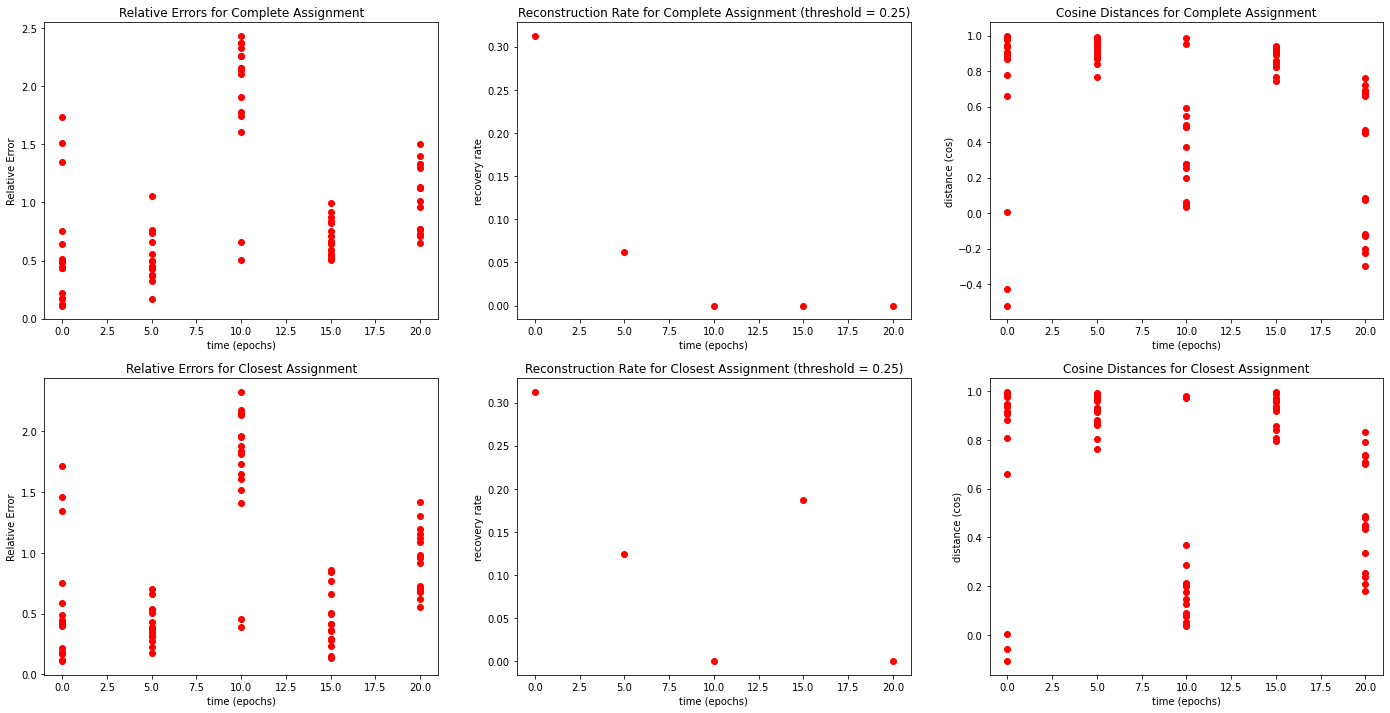

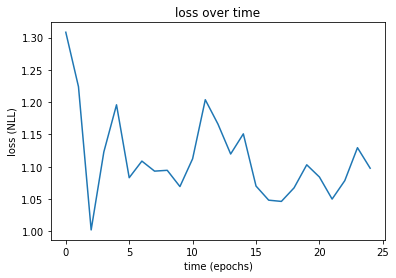

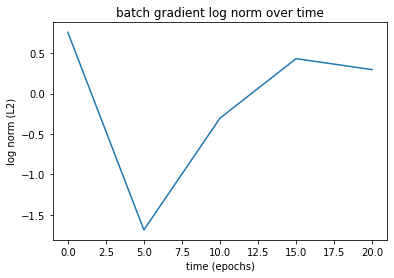

In [ ]:
# create summary plots of MSE and normalized errors over time
rows = 2; cols = 3
fig, axs = plt.subplots(rows, cols, figsize=(8*cols, 6*rows))

# complete assignment
axs[0, 0].plot(dlg_timestamps, AA_REs, 'ro')
axs[0, 0].set(title='Relative Errors for Complete Assignment', xlabel='time (epochs)', ylabel='Relative Error')

axs[0, 1].plot(dlg_timestamps, AA_RRate, 'ro')
axs[0, 1].set(title='Reconstruction Rate for Complete Assignment (threshold = 0.25)', xlabel='time (epochs)', ylabel='recovery rate')

axs[0, 2].plot(dlg_timestamps, AA_cos_angles, 'ro')
axs[0, 2].set(title='Cosine Distances for Complete Assignment', xlabel='time (epochs)', ylabel='distance (cos)')

# closest assignment
axs[1, 0].plot(dlg_timestamps, CA_REs, 'ro')
axs[1, 0].set(title='Relative Errors for Closest Assignment', xlabel='time (epochs)', ylabel='Relative Error')

axs[1, 1].plot(dlg_timestamps, CA_RRate, 'ro')
axs[1, 1].set(title='Reconstruction Rate for Closest Assignment (threshold = 0.25)', xlabel='time (epochs)', ylabel='recovery rate')

axs[1, 2].plot(dlg_timestamps, CA_cos_angles, 'ro')
axs[1, 2].set(title='Cosine Distances for Closest Assignment', xlabel='time (epochs)', ylabel='distance (cos)')

plt.savefig('train_DLG_16_big_errors.png', dpi=300)
plt.show()

plt.plot(list(range(epochs)), losses)
plt.title('loss over time')
plt.xlabel('time (epochs)')
plt.ylabel('loss (NLL)')
plt.savefig('train_DLG_16_big_loss.png', dpi=300)
plt.show()

plt.plot(dlg_timestamps, torch.log(torch.tensor(grad_norms)))
plt.title('batch gradient log norm over time')
plt.xlabel('time (epochs)')
plt.ylabel('log norm (L2)')
plt.savefig('train_DLG_16_big_norm.png', dpi=300)
plt.show()

In [ ]:
#@title Evolution Plots (not updated)
# evolution of SEs, normalized errors, cosine distances
fig, axs = plt.subplots(len(dlg_timestamps), 3, sharex='col', figsize=(24, len(dlg_timestamps)*4))

for i in range(len(dlg_timestamps)):
    axs[i, 0].hist(torch.log(torch.tensor(dlg_SEs[i])), 50)
    axs[i, 0].set(title=f'log SE of batch DLG at epoch {dlg_timestamps[i]}', xlabel='log SE', ylabel='frequency')

    axs[i, 1].hist(torch.log(torch.tensor(dlg_n_errors[i])), 50)
    axs[i, 1].set(title=f'log NE of batch DLG at epoch {dlg_timestamps[i]}', xlabel='log NE', ylabel='frequency')

    axs[i, 2].hist(dlg_cos_angles[i], 50)
    axs[i, 2].set(title=f'cosine distances of batch DLG at epoch {dlg_timestamps[i]}', xlabel='cosine distance', ylabel='frequency')

# Notes

In [ ]:
# Todo

# *consider using pickle to save variables e.g. DLG results (for changing labels of graphs / postprocessing)

# future tasks -----------------------------------------------------------
# also add comments to functions abstracted out into a package
# look at dp
# look at papers more related to FL
# estimate how quickly the model can be trained + attacked
# icml workshop for results
# consider other medical dataset
# possible idea - PCA with image tasks to capture similarity between reconstructed and true input data
# consider dropout with a probability like ~ 0.20-0.25 (or even, aggressively, 0.5 - good for generalization)